In [1]:
import sys
sys.path.append("..")
import shap
import xgboost
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import colorsys
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import manhattan_distances

In [2]:
shap.initjs()

In [3]:
# train XGBoost model
X,y = shap.datasets.diabetes()
X.head()
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

In [4]:
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [5]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [6]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X)

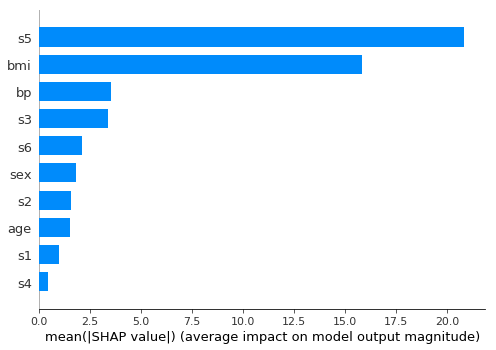

In [7]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X,plot_type = 'bar')

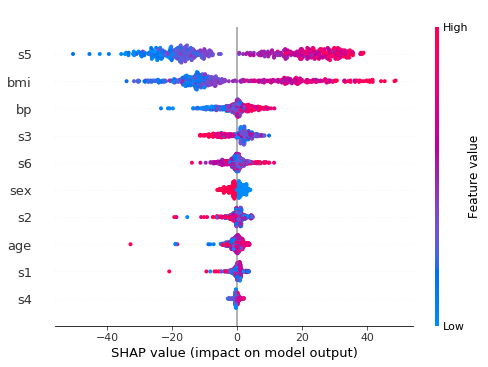

In [8]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X)

In [9]:
#Gather shapley values and output values in one dataframe
shap_dataframe = pd.DataFrame(data = shap_values,columns = X.columns)
output_dataframe = pd.DataFrame(data = y,columns = ['diabetes'])
shap_dataframe = pd.concat([shap_dataframe,output_dataframe],axis = 1)

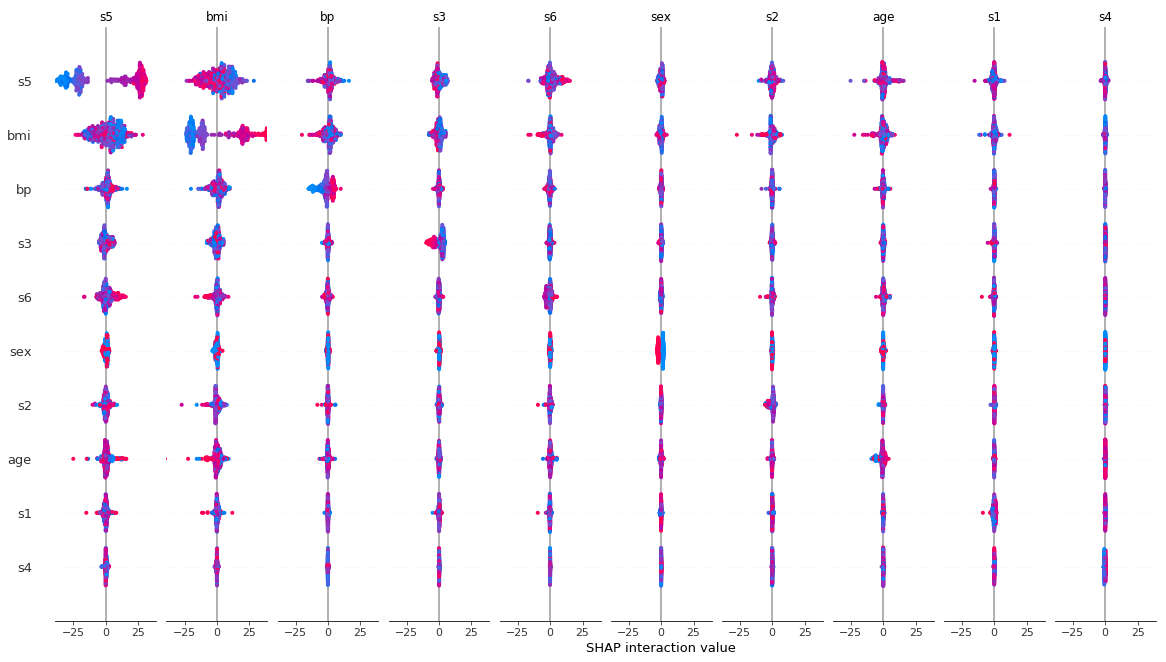

In [10]:
#Make interaction plot for all features
shap_interaction_values = explainer.shap_interaction_values(X)
shap.summary_plot(shap_interaction_values, X, max_display = 10)

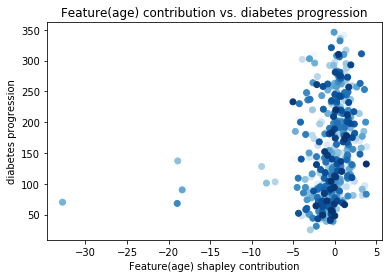

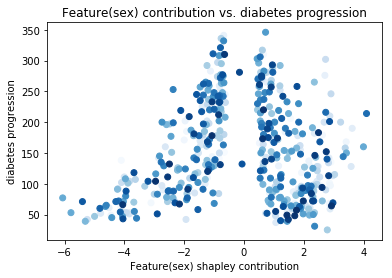

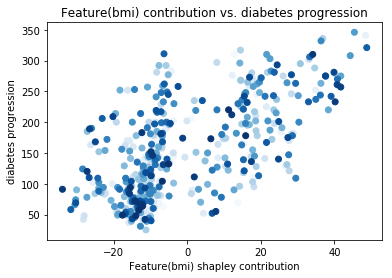

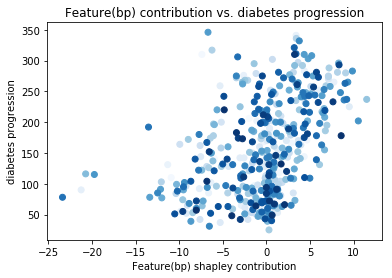

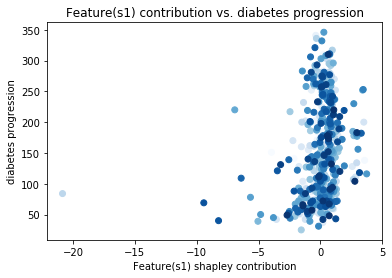

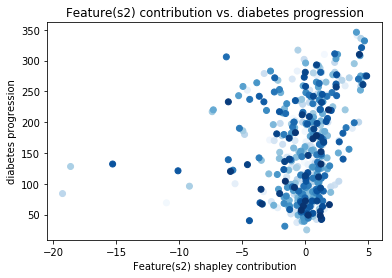

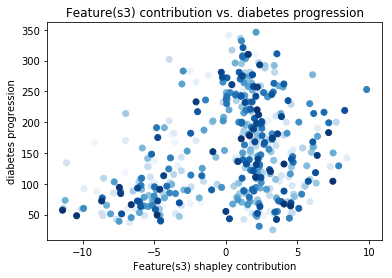

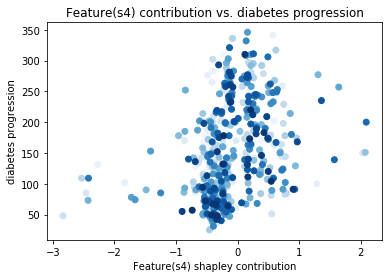

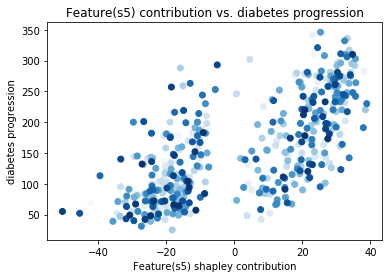

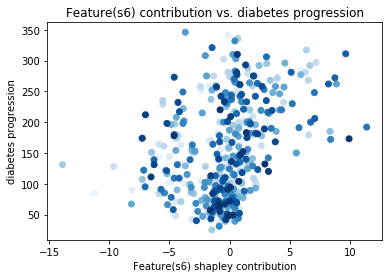

In [11]:
from Framework import plotHelper
plotHelper.plotAllFeatures(shap_dataframe)

In [12]:
#Start clustering
from Framework import cluster
from sklearn.cluster import KMeans
#Train KMeans, because the data is unsupervised(Regression data)
#kmeans = KMeans(n_clusters=3, random_state=0).fit(shap_values)
kmeans = cluster.clusterData(KMeans(n_clusters=3, random_state=0).fit,shap_values)

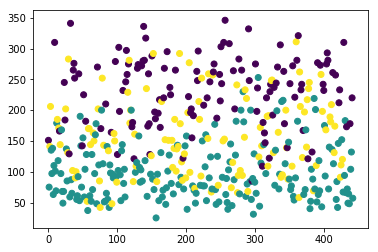

In [13]:
#Get the labels, concat into original data, and sor the labels for into cluster groups
shap_dataframe_labeled = pd.concat([shap_dataframe,pd.DataFrame(kmeans.labels_,columns =[ 'labels'])],axis = 1)
#shap_grouped = shap_dataframe_labeled.sort_values(['labels'])
X_labeled = pd.concat([X,shap_dataframe_labeled['labels']], axis = 1)
plt.scatter(np.linspace(0,442,442),y,c = X_labeled['labels'])

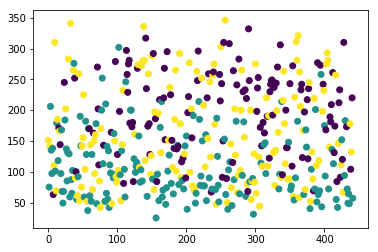

In [14]:
kmeans_original = cluster.clusterData(KMeans(n_clusters=3, random_state=0).fit,X)
plt.scatter(np.arange(len(X)),y,c = kmeans_original.labels_)

In [15]:
#Split the clusters into a dictionary
data_dict = cluster.splitDataLabeled(3,shap_dataframe,shap_dataframe_labeled['labels'])
data_dict_original = cluster.splitDataLabeled(3,X,kmeans_original.labels_)

In [16]:
#Convert the shapley clusters back to original data clusters
#original_data_cluster1 = X.iloc[shapley_cluster1.index.values]
#original_label_cluster1 = y[shapley_cluster1.index.values]
#original_data_cluster2 = X.iloc[shapley_cluster2.index.values]
#original_label_cluster2 = y[shapley_cluster2.index.values]
#original_data_cluster3 = X.iloc[shapley_cluster3.index.values]
#original_label_cluster3 = y[shapley_cluster3.index.values]

In [17]:
original_split = cluster.convertOriginalData(data_dict_original,X,y)
original_split_shapley = cluster.convertOriginalData(data_dict,X,y)
original_split_shapley

{'original_data_cluster0':           age       sex       bmi        bp        s1        s2        s3  \
 0    0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
 9   -0.070900 -0.044642  0.039062 -0.033214 -0.012577 -0.034508 -0.024993   
 16  -0.005515 -0.044642  0.042296  0.049415  0.024574 -0.023861  0.074412   
 23   0.045341  0.050680  0.060618  0.031053  0.028702 -0.047347 -0.054446   
 24  -0.063635 -0.044642  0.035829 -0.022885 -0.030464 -0.018850 -0.006584   
 30  -0.060003 -0.044642  0.044451 -0.019442 -0.009825 -0.007577  0.022869   
 32   0.034443  0.050680  0.125287  0.028758 -0.053855 -0.012900 -0.102307   
 36   0.012648 -0.044642  0.022895  0.052858  0.008063 -0.028558  0.037595   
 37  -0.009147 -0.044642  0.011039 -0.057314 -0.024960 -0.042963  0.030232   
 38  -0.001882  0.050680  0.071397  0.097616  0.087868  0.075407 -0.021311   
 44   0.045341  0.050680  0.068163  0.008101 -0.016704  0.004636 -0.076536   
 49  -0.041840  0.050680  0.014272 -0.

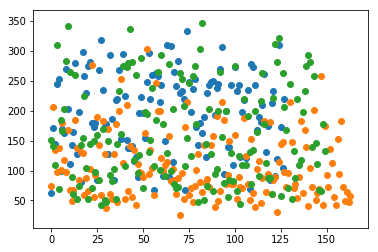

In [18]:
#Scatter the groups again...
#plt.scatter(np.linspace(-1,1,len(original_label_cluster2)),cluster2_predictions)
plt.scatter(np.arange(len(original_split['original_label_cluster0'])),original_split['original_label_cluster0'])
plt.scatter(np.arange(len(original_split['original_label_cluster1'])),original_split['original_label_cluster1'])
plt.scatter(np.arange(len(original_split['original_label_cluster2'])),original_split['original_label_cluster2'])

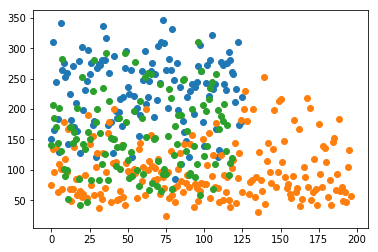

In [19]:
plt.scatter(np.arange(len(original_split_shapley['original_label_cluster0'])),original_split_shapley['original_label_cluster0'])
plt.scatter(np.arange(len(original_split_shapley['original_label_cluster1'])),original_split_shapley['original_label_cluster1'])
plt.scatter(np.arange(len(original_split_shapley['original_label_cluster2'])),original_split_shapley['original_label_cluster2'])

In [20]:
#Train split XGBoost models over original data
params = {
    "eta": 0.05,
    "max_depth": 1,
    "objective": "reg:squarederror",
    "subsample": 0.5,
    "base_score": np.mean(y),
    "eval_metric": "rmse"
}

kwargs = {
    'num_boost_round':40000,
    'verbose_eval': 5000
}

model_dict = cluster.trainMultipleModels(xgboost.train,original_split,'XGBoost',params,**kwargs)
#small_model_1 = xgboost.train(params,xgboost.DMatrix(original_split['original_data_cluster0'], label=original_split['original_label_cluster0']),20000,evals = [(xgboost.DMatrix(original_split['original_data_cluster0'], label=original_split['original_label_cluster0']), "train")] ,verbose_eval = 1000)
#small_model_2 = xgboost.train(params,xgboost.DMatrix(original_split['original_data_cluster1'], label=original_split['original_label_cluster1']),20000,evals = [(xgboost.DMatrix(original_split['original_data_cluster1'], label=original_split['original_label_cluster1']), "train")] ,verbose_eval = 1000)
#small_model_3 = xgboost.train(params,xgboost.DMatrix(original_split['original_data_cluster2'], label=original_split['original_label_cluster2']),20000,evals = [(xgboost.DMatrix(original_split['original_data_cluster2'], label=original_split['original_label_cluster2']), "train")] ,verbose_eval = 1000)

[0]	train-rmse:78.484
[5000]	train-rmse:10.1155


KeyboardInterrupt: 

In [29]:
#Train split XGBoost models over original data
params = {
    "eta": 0.05,
    "max_depth": 1,
    "objective": "reg:squarederror",
    "subsample": 0.5,
    "base_score": np.mean(y),
    "eval_metric": "rmse"
}
eval_results = {}
kwargs = {
    'num_boost_round':40000,
    'verbose_eval': 10000,
    'evals_result' : {}
}
model_dict_shapley,eval_results = cluster.trainMultipleModels(xgboost.train,original_split_shapley,'XGBoost',params,**kwargs)
eval_results
#small_model_shapley1 = xgboost.train(params,xgboost.DMatrix(original_split_shapley['original_data_cluster0'], label=original_split_shapley['original_label_cluster0']),20000,evals = [(xgboost.DMatrix(original_split_shapley['original_data_cluster0'], label=original_split_shapley['original_label_cluster0']), "train")] ,verbose_eval = 1000)
#small_model_shapley2 = xgboost.train(params,xgboost.DMatrix(original_split_shapley['original_data_cluster1'], label=original_split_shapley['original_label_cluster1']),20000,evals = [(xgboost.DMatrix(original_split_shapley['original_data_cluster1'], label=original_split_shapley['original_label_cluster1']), "train")] ,verbose_eval = 1000)
#small_model_shapley3 = xgboost.train(params,xgboost.DMatrix(original_split_shapley['original_data_cluster2'], label=original_split_shapley['original_label_cluster2']),20000,evals = [(xgboost.DMatrix(original_split_shapley['original_data_cluster2'], label=original_split_shapley['original_label_cluster2']), "train")] ,verbose_eval = 1000)

[0]	train-rmse:93.8155
[10000]	train-rmse:2.58087
[20000]	train-rmse:0.397743
[30000]	train-rmse:0.086441
[39999]	train-rmse:0.018629
[0]	train-rmse:68.0466
[10000]	train-rmse:9.03885
[20000]	train-rmse:4.19664
[30000]	train-rmse:2.19997
[39999]	train-rmse:1.20286
[0]	train-rmse:62.8143
[10000]	train-rmse:3.83031
[20000]	train-rmse:0.617631
[30000]	train-rmse:0.112901
[39999]	train-rmse:0.021296


{'eval0': {'train': {'rmse': [93.815468,
    90.603859,
    87.473267,
    84.433685,
    81.923058,
    79.782043,
    77.677483,
    75.495285,
    73.728745,
    71.73745,
    70.069557,
    68.662903,
    66.957893,
    65.770119,
    64.410706,
    63.387825,
    62.155434,
    60.966808,
    60.121681,
    59.174316,
    58.200111,
    57.419479,
    56.722023,
    55.806873,
    54.981758,
    54.26532,
    53.789173,
    53.231503,
    52.827171,
    52.469879,
    52.179897,
    51.963844,
    51.605042,
    51.255535,
    50.963161,
    50.663654,
    50.298832,
    50.097431,
    49.875916,
    49.672783,
    49.548306,
    49.379639,
    49.174644,
    49.001053,
    48.741486,
    48.592941,
    48.43504,
    48.246075,
    48.150024,
    48.001148,
    47.829529,
    47.728676,
    47.595337,
    47.459778,
    47.236263,
    47.11224,
    46.982895,
    46.875256,
    46.766567,
    46.65221,
    46.530434,
    46.493343,
    46.398067,
    46.305038,
    46.214375,
    

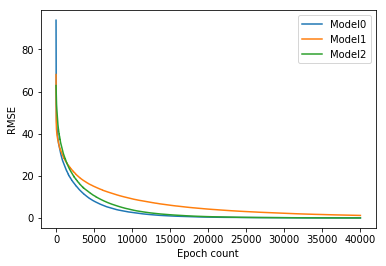

In [30]:
plt.plot(np.arange(len(eval_results['eval0']['train']['rmse'])),eval_results['eval0']['train']['rmse'])
plt.plot(np.arange(len(eval_results['eval1']['train']['rmse'])),eval_results['eval1']['train']['rmse'])
plt.plot(np.arange(len(eval_results['eval2']['train']['rmse'])),eval_results['eval2']['train']['rmse'])
plt.xlabel('Epoch count')
plt.ylabel('RMSE')
plt.legend(['Model0','Model1','Model2'])

In [ ]:
#preds =model.predict(xgboost.DMatrix(original_split['original_data_cluster0']))
plt.scatter(np.arange(len(original_split['original_label_cluster0'])),original_split['original_label_cluster0'])
plt.scatter(np.arange(len(original_split['original_label_cluster0'])),model_dict['model0'].predict(xgboost.DMatrix(original_split['original_data_cluster0'])))

In [ ]:
#preds =model.predict(xgboost.DMatrix(original_split['original_data_cluster0']))
plt.scatter(np.arange(len(original_split_shapley['original_label_cluster0'])),original_split_shapley['original_label_cluster0'])
plt.scatter(np.arange(len(original_split_shapley['original_label_cluster0'])),model_dict_shapley['model0'].predict(xgboost.DMatrix(original_split_shapley['original_data_cluster0'])))

In [38]:
#Train overall model
ev_result = {}
params = {
    "eta": 0.05,
    "max_depth": 1,
    "objective": "reg:squarederror",
    "subsample": 0.5,
    "base_score": np.mean(y),
    "eval_metric": "rmse",
}
model = xgboost.train(params,xgboost.DMatrix(X, label=y),40000,evals = [(xgboost.DMatrix(X, label=y), "train")] ,verbose_eval = 5000,evals_result = ev_result)


[0]	train-rmse:75.9111
[5000]	train-rmse:33.359
[10000]	train-rmse:27.0135
[15000]	train-rmse:22.8623
[20000]	train-rmse:19.8266
[25000]	train-rmse:17.3785
[30000]	train-rmse:15.4512
[35000]	train-rmse:13.8283
[39999]	train-rmse:12.4463


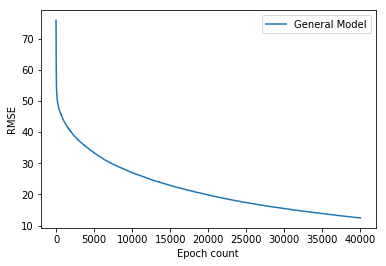

In [39]:
plt.plot(np.arange(len(ev_result['train']['rmse'])),ev_result['train']['rmse'])
plt.xlabel('Epoch count')
plt.ylabel('RMSE')
plt.legend(['General Model'])

In [ ]:
plt.scatter(np.arange(len(X)),y)
plt.scatter(np.arange(len(X)),model.predict(xgboost.DMatrix(X)))

In [ ]:
#Do PCA for dimensionality reduction
pca = PCA(n_components=2)
shap_values_pca = pca.fit_transform(shap_values)
print(pca.explained_variance_ratio_.sum())

In [ ]:
#PCA Clusters are quite seperate,could be used in clustering
plt.scatter(shap_values_pca[:,0],shap_values_pca[:,1], c = kmeans.labels_)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
#Add to labels to the scatter plot (Colors)
#How do we interpret this ?

In [ ]:
mu = np.mean(shap_values, axis=0)
Xhat = np.dot(shap_values_pca[:,:2], pca.components_[:2,:])
Xhat += mu
Xhat[1,:]

In [ ]:
mindex = np.argmin(manhattan_distances(Xhat,shap_values_pca),axis = 0)
mindex